In [2]:
import torch 
from torch import Tensor 
import numpy as np
import math
import matplotlib.pyplot as plt
import math

In [95]:
class Relu:
    def forward(self, x):   
        self.x = x.clone()
        return x.clamp(min=0)
    
    def backward(self, dz):
        output = self.x.clone()
        output[output > 0] = 1
        output[output < 0] = 0
#         print("forwarded x")
#         print(self.x[:5])
#         print("output")
#         print(output[:5])
#         print("dz come")
#         print(dz[:5])
#         print("backwarded update")
#         print(dz.mul(output).shape)
        return dz.mul(output)

In [121]:
class Tanh:
    
    def forward(self, x):
        self.x = x.clone()
        self.output = Tensor.tanh(x)
        return self.output;

    def backward(self, dz):
#         print("forwarded x")
#         print(self.x[:5])
#         print("output")
#         print(self.output[:5])
#         print("dz come")
#         print(dz[:5])
#         print("backwarded update")
#         print(dz.mul(1.0 - Tensor.tanh(self.x).pow(2))[:5])
        return dz.mul(1.0 - Tensor.tanh(self.x).pow(2))
        

In [155]:
class Linear:
    
    def __init__(self, input_size ,hidden_nodes):    
        
        # Initialize weight, bias xavie initializer
        stdv = 1. / math.sqrt(input_size)
        self.w = Tensor(hidden_nodes, input_size).uniform_(-stdv, stdv)
        self.b = Tensor(hidden_nodes).uniform_(-stdv, stdv) 
        self.dw = Tensor(self.w.size()).zero_()
        self.db = Tensor(self.b.size()).zero_()
#         self.db = Tensor(self.b.size()).normal_(-10,100)
#         self.dw = Tensor(self.w.size()).normal_(-10,100)
        
    def forward(self, x):
        self.x = x.clone()
        s = x.matmul(self.w.t()) + self.b
        return s
        
    def backward(self, dz):
        
        dx = dz.matmul(self.w)
        dw = self.x.t().matmul(dz)
        db = dz.t().sum(1)
        
        self.dw += dw
        self.db += db
        
        return dx
        
    def params(self):
        return (self.w, self.b, self.dw,self.db)
    
    
    def update_params(self, lambda_):
        self.w -= lambda_ * self.dw
        self.b -= lambda_ * self.db
        
    
    def zero_gradient(self):
        self.dw.zero_()
        self.db.zero_()

In [169]:
class LossMSE: 
        
    def forward(self, t, x):
        self.t = t.clone()
        self.x = x.clone()
        self.output = (self.x - self.t).pow(2).mean()

        return self.output
    
    def backward(self):
#         print("t")
#         print(self.t)
#         print("x")
#         print(self.x)
#         print("error")
#         print(self.output)
        dloss = 2 * (self.t - self.x)/self.x.shape[0]/2
#         print(self.x.shape)
        return dloss

In [39]:
class Sequential:
    
    def __init__(self, layer_modules):
        self.layer_modules = layer_modules

        
    def forward(self, x_input):
        module_input = x_input.clone()
        
        # hidden layer
        for i in range(len(self.layer_modules)): 
            module_output = self.layer_modules[i].forward(module_input)
            module_input = module_output
        return module_output
    
    def backward(self, dz):
        for i in range(len(self.layer_modules) - 1, -1, -1):
            dz = self.layer_modules[i].backward(dz) 
    
    def update_params(self, lambda_):
        for m in self.layer_modules:
            if isinstance(m, Linear): 
                m.update_params(lambda_);

    
    def zero_gradient(self):
        for m in self.layer_modules:
            if isinstance(m, Linear):
                m.zero_gradient()
    
    def get_params(self):
        for m in self.layer_modules:
            print('{},{}'.format(m.params()[0], m.params()[1]))


In [69]:
def train_model(model, train_input, train_target, test_input, test_target, nb_epochs, lr,mini_batch_size ):
    
    criterion = LossMSE()
    
    for m in range(nb_epochs):

        total_loss = 0    
        
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model.forward(train_input.narrow(0, b, mini_batch_size))
#             print(output)
            total_loss  += criterion.forward(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_gradient()
            dloss = criterion.backward()
#             print("dloss")
#             print(dloss[:5])
            model.backward(dloss)
            model.update_params(lr)
        
        train_errors = compute_nb_errors(model, train_input, train_target)
        test_errors = compute_nb_errors(model, test_input, test_target)
        print("================================{}===================================".format(m))
        
        print(  '{}/{}: train_loss: {} train_error {:.02f}% test_error {:.02f}%'.format(m , nb_epochs,total_loss,
                train_errors/ train_input.size(0) * 100,
                test_errors / test_input.size(0) * 100))  

def compute_nb_errors(model, data_input, data_target):

    nb_data_errors = 0

    for b in range(0, data_input.size(0), mini_batch_size):
        output = model.forward(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes = torch.max(output, 1)
        for k in range(0, mini_batch_size):
            if data_target[b + k][predicted_classes[k]]  < 0:
                nb_data_errors = nb_data_errors + 1

    return nb_data_errors

### Generate data

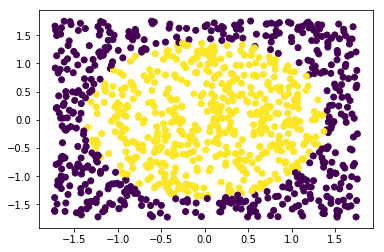

In [47]:
data = torch.FloatTensor(1000,2).uniform_(0, 1) - 0.5
distance = torch.sqrt(torch.pow(data[:, 0], 2) + torch.pow(data[:,1],2)).view(-1,1)
radius = 1 / math.sqrt(2 * math.pi)
inside = distance.clone().apply_(lambda x : 1 if x < radius else  -1)
outside = distance.clone().apply_(lambda x : 1 if x > radius else  -1)

target = torch.cat((inside, outside),1)


data = (data - data.mean())/ data.std()
# plt.scatter(data[:,0], data[:,1], c=inside)
# plt.show()
plt.scatter(data[:,0], data[:,1], c=inside.squeeze())
plt.show()

## Train model

In [170]:
lr =  1e-3
mini_batch_size = 200
nb_epochs = 4000
# modules = [Linear(2, 25), Relu(),Linear(25, 25),Relu(),Linear(25, 25),Relu(),Linear(25, 2), Tanh()]
modules = [Linear(2, 25), Relu(),Linear(25, 2), Tanh()]
model = Sequential(modules)

train_input, train_target, test_input, test_target = data[0:800,], target[0:800,], data[800:,], target[800:,]

train_model(model, train_input, train_target, test_input, test_target, nb_epochs, lr, mini_batch_size)


/home/cheng-chun-epfl/anaconda3/lib/python3.6/site-packages/torch/tensor.py:309: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)


================================0===================================
0/4000: train_loss: 4.780328210016014 train_error 57.00% test_error 58.00%
================================1===================================
1/4000: train_loss: 4.777900358905317 train_error 56.88% test_error 58.00%
================================2===================================
2/4000: train_loss: 4.7754955504520336 train_error 56.75% test_error 58.00%
================================3===================================
3/4000: train_loss: 4.773112261058995 train_error 56.62% test_error 58.50%
================================4===================================
4/4000: train_loss: 4.7707496307545805 train_error 56.75% test_error 58.00%
================================5===================================
5/4000: train_loss: 4.76840884860605 train_error 56.75% test_error 58.00%
================================6===================================
6/4000: train_loss: 4.766089662672021 train_error 56.75% test_erro

================================66===================================
66/4000: train_loss: 4.658360312331934 train_error 54.25% test_error 58.00%
================================67===================================
67/4000: train_loss: 4.656980329535436 train_error 54.37% test_error 58.00%
================================68===================================
68/4000: train_loss: 4.65561136605218 train_error 54.62% test_error 58.50%
================================69===================================
69/4000: train_loss: 4.654253007166553 train_error 54.75% test_error 58.50%
================================70===================================
70/4000: train_loss: 4.652905130139551 train_error 54.75% test_error 58.50%
================================71===================================
71/4000: train_loss: 4.651566819066648 train_error 54.87% test_error 58.00%
================================72===================================
72/4000: train_loss: 4.650237467421684 train_error 54.8

================================130===================================
130/4000: train_loss: 4.587112747994251 train_error 55.88% test_error 58.50%
================================131===================================
131/4000: train_loss: 4.586213428317569 train_error 55.88% test_error 58.50%
================================132===================================
132/4000: train_loss: 4.585319272917696 train_error 55.88% test_error 58.50%
================================133===================================
133/4000: train_loss: 4.5844299992383455 train_error 55.88% test_error 58.50%
================================134===================================
134/4000: train_loss: 4.58354515839601 train_error 56.00% test_error 58.50%
================================135===================================
135/4000: train_loss: 4.582665899242274 train_error 56.00% test_error 58.50%
================================136===================================
136/4000: train_loss: 4.581791706979275 t

================================198===================================
198/4000: train_loss: 4.535134818227961 train_error 53.62% test_error 56.00%
================================199===================================
199/4000: train_loss: 4.534470596774481 train_error 53.62% test_error 56.00%
================================200===================================
200/4000: train_loss: 4.5338085769861936 train_error 53.62% test_error 56.00%
================================201===================================
201/4000: train_loss: 4.533148775692098 train_error 53.62% test_error 55.50%
================================202===================================
202/4000: train_loss: 4.532489870977589 train_error 53.87% test_error 55.00%
================================203===================================
203/4000: train_loss: 4.531832544947974 train_error 53.87% test_error 55.00%
================================204===================================
204/4000: train_loss: 4.531177538712509 

================================263===================================
263/4000: train_loss: 4.495131015572697 train_error 52.50% test_error 52.00%
================================264===================================
264/4000: train_loss: 4.494544446477667 train_error 52.50% test_error 52.00%
================================265===================================
265/4000: train_loss: 4.493959274827502 train_error 52.38% test_error 52.00%
================================266===================================
266/4000: train_loss: 4.493376688212156 train_error 52.38% test_error 52.00%
================================267===================================
267/4000: train_loss: 4.492794258161448 train_error 52.25% test_error 52.00%
================================268===================================
268/4000: train_loss: 4.492212342000567 train_error 52.00% test_error 52.50%
================================269===================================
269/4000: train_loss: 4.4916308775357905 

================================335===================================
335/4000: train_loss: 4.454404218299315 train_error 50.50% test_error 52.50%
================================336===================================
336/4000: train_loss: 4.453841399154626 train_error 50.38% test_error 52.50%
================================337===================================
337/4000: train_loss: 4.453277716618031 train_error 50.38% test_error 52.50%
================================338===================================
338/4000: train_loss: 4.4527125670062375 train_error 50.38% test_error 52.00%
================================339===================================
339/4000: train_loss: 4.4521467573754485 train_error 50.38% test_error 52.00%
================================340===================================
340/4000: train_loss: 4.451581355277449 train_error 50.25% test_error 52.00%
================================341===================================
341/4000: train_loss: 4.451017183456569

================================402===================================
402/4000: train_loss: 4.41533622588031 train_error 48.50% test_error 53.00%
================================403===================================
403/4000: train_loss: 4.414737568334676 train_error 48.50% test_error 53.00%
================================404===================================
404/4000: train_loss: 4.41413765901234 train_error 48.50% test_error 53.00%
================================405===================================
405/4000: train_loss: 4.413536792765372 train_error 48.50% test_error 53.00%
================================406===================================
406/4000: train_loss: 4.412935823313893 train_error 48.38% test_error 53.00%
================================407===================================
407/4000: train_loss: 4.412331366669386 train_error 48.25% test_error 53.00%
================================408===================================
408/4000: train_loss: 4.411722045666538 tra

================================502===================================
502/4000: train_loss: 4.34900312811602 train_error 46.38% test_error 52.00%
================================503===================================
503/4000: train_loss: 4.348270320780575 train_error 46.25% test_error 52.00%
================================504===================================
504/4000: train_loss: 4.347537467256188 train_error 46.25% test_error 52.00%
================================505===================================
505/4000: train_loss: 4.346802700934932 train_error 46.12% test_error 52.00%
================================506===================================
506/4000: train_loss: 4.346067725475877 train_error 46.12% test_error 52.00%
================================507===================================
507/4000: train_loss: 4.345331639070064 train_error 46.12% test_error 52.00%
================================508===================================
508/4000: train_loss: 4.344594473154284 tr

================================597===================================
597/4000: train_loss: 4.272193843009881 train_error 44.12% test_error 51.00%
================================598===================================
598/4000: train_loss: 4.2713194103864955 train_error 44.25% test_error 51.00%
================================599===================================
599/4000: train_loss: 4.270446086334996 train_error 44.25% test_error 51.00%
================================600===================================
600/4000: train_loss: 4.269572385675274 train_error 44.25% test_error 51.00%
================================601===================================
601/4000: train_loss: 4.268697467958555 train_error 44.12% test_error 51.00%
================================602===================================
602/4000: train_loss: 4.26782020425424 train_error 44.12% test_error 50.50%
================================603===================================
603/4000: train_loss: 4.266941665196791 t

================================693===================================
693/4000: train_loss: 4.182894856673665 train_error 42.25% test_error 49.00%
================================694===================================
694/4000: train_loss: 4.181903911693953 train_error 42.25% test_error 49.00%
================================695===================================
695/4000: train_loss: 4.18091202522628 train_error 42.25% test_error 49.00%
================================696===================================
696/4000: train_loss: 4.179919486618601 train_error 42.25% test_error 49.00%
================================697===================================
697/4000: train_loss: 4.1789282531524075 train_error 42.12% test_error 49.00%
================================698===================================
698/4000: train_loss: 4.177936690156348 train_error 42.12% test_error 49.00%
================================699===================================
699/4000: train_loss: 4.176943685524165 t

================================789===================================
789/4000: train_loss: 4.081321773035452 train_error 40.50% test_error 47.00%
================================790===================================
790/4000: train_loss: 4.080194766269996 train_error 40.50% test_error 47.00%
================================791===================================
791/4000: train_loss: 4.079066441990435 train_error 40.50% test_error 47.00%
================================792===================================
792/4000: train_loss: 4.07793823983986 train_error 40.50% test_error 47.00%
================================793===================================
793/4000: train_loss: 4.07680789580103 train_error 40.50% test_error 47.00%
================================794===================================
794/4000: train_loss: 4.075673860055394 train_error 40.50% test_error 47.00%
================================795===================================
795/4000: train_loss: 4.074538634680211 tra

================================884===================================
884/4000: train_loss: 3.9685811256710437 train_error 38.00% test_error 46.50%
================================885===================================
885/4000: train_loss: 3.9673375735245644 train_error 38.00% test_error 46.50%
================================886===================================
886/4000: train_loss: 3.966092687775381 train_error 38.00% test_error 46.50%
================================887===================================
887/4000: train_loss: 3.964844684880227 train_error 38.00% test_error 46.50%
================================888===================================
888/4000: train_loss: 3.963593730940483 train_error 37.88% test_error 46.50%
================================889===================================
889/4000: train_loss: 3.9623397526144983 train_error 37.88% test_error 46.50%
================================890===================================
890/4000: train_loss: 3.96108539519365

================================989===================================
989/4000: train_loss: 3.8331634473614393 train_error 36.25% test_error 43.00%
================================990===================================
990/4000: train_loss: 3.831837032092735 train_error 36.25% test_error 43.00%
================================991===================================
991/4000: train_loss: 3.8305105018196626 train_error 36.25% test_error 43.00%
================================992===================================
992/4000: train_loss: 3.829183224271983 train_error 36.25% test_error 43.00%
================================993===================================
993/4000: train_loss: 3.8278545078402386 train_error 36.25% test_error 43.00%
================================994===================================
994/4000: train_loss: 3.826525300070643 train_error 36.50% test_error 43.00%
================================995===================================
995/4000: train_loss: 3.82519661674741

================================1061===================================
1061/4000: train_loss: 3.736347413393669 train_error 35.38% test_error 42.00%
================================1062===================================
1062/4000: train_loss: 3.7349959519738336 train_error 35.25% test_error 42.00%
================================1063===================================
1063/4000: train_loss: 3.7336437050020317 train_error 35.25% test_error 42.00%
================================1064===================================
1064/4000: train_loss: 3.732290301276371 train_error 35.25% test_error 42.00%
================================1065===================================
1065/4000: train_loss: 3.730937078688293 train_error 35.25% test_error 42.00%
================================1066===================================
1066/4000: train_loss: 3.729584144842811 train_error 35.25% test_error 42.00%
================================1067===================================
1067/4000: train_loss: 3.7

================================1134===================================
1134/4000: train_loss: 3.637547123837285 train_error 32.75% test_error 42.00%
================================1135===================================
1135/4000: train_loss: 3.636192978098989 train_error 32.75% test_error 42.00%
================================1136===================================
1136/4000: train_loss: 3.634839036096819 train_error 32.75% test_error 42.00%
================================1137===================================
1137/4000: train_loss: 3.6334839204978198 train_error 32.62% test_error 42.00%
================================1138===================================
1138/4000: train_loss: 3.632128869523294 train_error 32.62% test_error 42.00%
================================1139===================================
1139/4000: train_loss: 3.630774512360804 train_error 32.62% test_error 42.00%
================================1140===================================
1140/4000: train_loss: 3.62

================================1206===================================
1206/4000: train_loss: 3.541775749656372 train_error 30.00% test_error 40.00%
================================1207===================================
1207/4000: train_loss: 3.5404830883583056 train_error 30.00% test_error 40.00%
================================1208===================================
1208/4000: train_loss: 3.539191630417481 train_error 30.00% test_error 40.00%
================================1209===================================
1209/4000: train_loss: 3.5379023798136036 train_error 30.00% test_error 40.00%
================================1210===================================
1210/4000: train_loss: 3.5366144718416033 train_error 30.00% test_error 40.00%
================================1211===================================
1211/4000: train_loss: 3.535327237397432 train_error 30.00% test_error 40.00%
================================1212===================================
1212/4000: train_loss: 3.

================================1277===================================
1277/4000: train_loss: 3.454117591269314 train_error 27.75% test_error 37.50%
================================1278===================================
1278/4000: train_loss: 3.4529420823697 train_error 27.75% test_error 37.50%
================================1279===================================
1279/4000: train_loss: 3.4517680661287153 train_error 27.75% test_error 37.50%
================================1280===================================
1280/4000: train_loss: 3.450595441097394 train_error 27.75% test_error 37.50%
================================1281===================================
1281/4000: train_loss: 3.4494244862301273 train_error 27.62% test_error 37.50%
================================1282===================================
1282/4000: train_loss: 3.448255762504414 train_error 27.62% test_error 37.50%
================================1283===================================
1283/4000: train_loss: 3.447

================================1379===================================
1379/4000: train_loss: 3.3418309484189375 train_error 24.75% test_error 34.50%
================================1380===================================
1380/4000: train_loss: 3.3408103037439285 train_error 24.75% test_error 34.50%
================================1381===================================
1381/4000: train_loss: 3.3397909656353297 train_error 24.75% test_error 34.50%
================================1382===================================
1382/4000: train_loss: 3.3387722034100444 train_error 24.75% test_error 34.50%
================================1383===================================
1383/4000: train_loss: 3.337754533085972 train_error 24.75% test_error 34.50%
================================1384===================================
1384/4000: train_loss: 3.3367382836528123 train_error 24.75% test_error 34.50%
================================1385===================================
1385/4000: train_loss: 

================================1473===================================
1473/4000: train_loss: 3.251528010931797 train_error 24.25% test_error 33.00%
================================1474===================================
1474/4000: train_loss: 3.2506403168756512 train_error 24.25% test_error 33.00%
================================1475===================================
1475/4000: train_loss: 3.2497549588372934 train_error 24.25% test_error 33.00%
================================1476===================================
1476/4000: train_loss: 3.2488716311007737 train_error 24.25% test_error 33.00%
================================1477===================================
1477/4000: train_loss: 3.2479894859250633 train_error 24.12% test_error 33.00%
================================1478===================================
1478/4000: train_loss: 3.2471088500740004 train_error 24.12% test_error 33.00%
================================1479===================================
1479/4000: train_loss: 

================================1567===================================
1567/4000: train_loss: 3.1754412829037757 train_error 23.50% test_error 31.50%
================================1568===================================
1568/4000: train_loss: 3.17471071720589 train_error 23.50% test_error 31.50%
================================1569===================================
1569/4000: train_loss: 3.173981612804346 train_error 23.50% test_error 31.50%
================================1570===================================
1570/4000: train_loss: 3.173253837591037 train_error 23.50% test_error 31.50%
================================1571===================================
1571/4000: train_loss: 3.172527033286169 train_error 23.50% test_error 31.50%
================================1572===================================
1572/4000: train_loss: 3.1718013194156813 train_error 23.50% test_error 31.50%
================================1573===================================
1573/4000: train_loss: 3.17

================================1685===================================
1685/4000: train_loss: 3.100334306424484 train_error 24.62% test_error 31.00%
================================1686===================================
1686/4000: train_loss: 3.0997836697008463 train_error 24.62% test_error 31.00%
================================1687===================================
1687/4000: train_loss: 3.0992322796257215 train_error 24.62% test_error 31.00%
================================1688===================================
1688/4000: train_loss: 3.098677598480135 train_error 24.62% test_error 31.00%
================================1689===================================
1689/4000: train_loss: 3.0981238214252516 train_error 24.62% test_error 31.00%
================================1690===================================
1690/4000: train_loss: 3.0975715379323807 train_error 24.62% test_error 31.00%
================================1691===================================
1691/4000: train_loss: 3

================================1758===================================
1758/4000: train_loss: 3.062569677014835 train_error 24.62% test_error 31.50%
================================1759===================================
1759/4000: train_loss: 3.0620874796668067 train_error 24.62% test_error 31.50%
================================1760===================================
1760/4000: train_loss: 3.061604369212873 train_error 24.62% test_error 31.50%
================================1761===================================
1761/4000: train_loss: 3.061122550982982 train_error 24.75% test_error 31.50%
================================1762===================================
1762/4000: train_loss: 3.0606418995838616 train_error 24.75% test_error 31.50%
================================1763===================================
1763/4000: train_loss: 3.0601621476793666 train_error 24.75% test_error 31.50%
================================1764===================================
1764/4000: train_loss: 3.

================================1827===================================
1827/4000: train_loss: 3.030823743352667 train_error 24.12% test_error 29.50%
================================1828===================================
1828/4000: train_loss: 3.030396241797134 train_error 24.12% test_error 29.50%
================================1829===================================
1829/4000: train_loss: 3.0299699202133343 train_error 24.12% test_error 29.50%
================================1830===================================
1830/4000: train_loss: 3.0295465579815213 train_error 24.12% test_error 29.50%
================================1831===================================
1831/4000: train_loss: 3.0291230179788546 train_error 24.25% test_error 29.50%
================================1832===================================
1832/4000: train_loss: 3.028697060025297 train_error 24.25% test_error 29.50%
================================1833===================================
1833/4000: train_loss: 3.

================================1900===================================
1900/4000: train_loss: 3.000708816437982 train_error 23.38% test_error 27.00%
================================1901===================================
1901/4000: train_loss: 3.000296199750155 train_error 23.38% test_error 27.00%
================================1902===================================
1902/4000: train_loss: 2.9998815307067708 train_error 23.38% test_error 27.50%
================================1903===================================
1903/4000: train_loss: 2.9994675210956485 train_error 23.38% test_error 27.50%
================================1904===================================
1904/4000: train_loss: 2.9990557323163376 train_error 23.38% test_error 27.50%
================================1905===================================
1905/4000: train_loss: 2.9986455624550583 train_error 23.38% test_error 27.50%
================================1906===================================
1906/4000: train_loss: 2

================================1959===================================
1959/4000: train_loss: 2.9772009568475184 train_error 23.38% test_error 25.50%
================================1960===================================
1960/4000: train_loss: 2.976817264282145 train_error 23.38% test_error 25.50%
================================1961===================================
1961/4000: train_loss: 2.97643523984123 train_error 23.50% test_error 25.00%
================================1962===================================
1962/4000: train_loss: 2.9760540379630402 train_error 23.38% test_error 25.00%
================================1963===================================
1963/4000: train_loss: 2.9756730049382893 train_error 23.38% test_error 25.00%
================================1964===================================
1964/4000: train_loss: 2.9752923342073334 train_error 23.38% test_error 25.00%
================================1965===================================
1965/4000: train_loss: 2.

================================2076===================================
2076/4000: train_loss: 2.9296046299673617 train_error 22.62% test_error 25.00%
================================2077===================================
2077/4000: train_loss: 2.92919059954118 train_error 22.62% test_error 25.00%
================================2078===================================
2078/4000: train_loss: 2.9287759127840403 train_error 22.62% test_error 25.00%
================================2079===================================
2079/4000: train_loss: 2.928360049105249 train_error 22.62% test_error 25.00%
================================2080===================================
2080/4000: train_loss: 2.9279427682375534 train_error 22.62% test_error 25.00%
================================2081===================================
2081/4000: train_loss: 2.927522192322649 train_error 22.62% test_error 25.00%
================================2082===================================
2082/4000: train_loss: 2.9

================================2145===================================
2145/4000: train_loss: 2.8987773941969497 train_error 22.62% test_error 25.00%
================================2146===================================
2146/4000: train_loss: 2.8983333510160447 train_error 22.75% test_error 25.00%
================================2147===================================
2147/4000: train_loss: 2.897889653835446 train_error 22.75% test_error 25.00%
================================2148===================================
2148/4000: train_loss: 2.897445391961374 train_error 22.75% test_error 25.00%
================================2149===================================
2149/4000: train_loss: 2.897001651213505 train_error 22.75% test_error 25.00%
================================2150===================================
2150/4000: train_loss: 2.8965583480754864 train_error 22.75% test_error 25.00%
================================2151===================================
2151/4000: train_loss: 2.

================================2252===================================
2252/4000: train_loss: 2.847901823304128 train_error 22.88% test_error 25.00%
================================2253===================================
2253/4000: train_loss: 2.847380984718911 train_error 22.75% test_error 25.00%
================================2254===================================
2254/4000: train_loss: 2.8468593318597413 train_error 22.75% test_error 25.00%
================================2255===================================
2255/4000: train_loss: 2.846337097599171 train_error 22.75% test_error 25.50%
================================2256===================================
2256/4000: train_loss: 2.845812400786672 train_error 22.75% test_error 25.50%
================================2257===================================
2257/4000: train_loss: 2.8452858941769223 train_error 22.75% test_error 25.50%
================================2258===================================
2258/4000: train_loss: 2.8

================================2322===================================
2322/4000: train_loss: 2.808201874643564 train_error 22.62% test_error 23.50%
================================2323===================================
2323/4000: train_loss: 2.8075929167424327 train_error 22.62% test_error 23.50%
================================2324===================================
2324/4000: train_loss: 2.806978226234205 train_error 22.62% test_error 23.50%
================================2325===================================
2325/4000: train_loss: 2.806364443607163 train_error 22.62% test_error 23.50%
================================2326===================================
2326/4000: train_loss: 2.805752270917874 train_error 22.62% test_error 23.50%
================================2327===================================
2327/4000: train_loss: 2.805141224707477 train_error 22.62% test_error 23.50%
================================2328===================================
2328/4000: train_loss: 2.80

================================2394===================================
2394/4000: train_loss: 2.7629911223100496 train_error 21.88% test_error 24.50%
================================2395===================================
2395/4000: train_loss: 2.762347571789287 train_error 21.88% test_error 24.50%
================================2396===================================
2396/4000: train_loss: 2.7617032406316135 train_error 21.88% test_error 24.50%
================================2397===================================
2397/4000: train_loss: 2.761057107478846 train_error 22.00% test_error 24.50%
================================2398===================================
2398/4000: train_loss: 2.760413256196771 train_error 22.00% test_error 24.50%
================================2399===================================
2399/4000: train_loss: 2.7597649248782545 train_error 22.00% test_error 24.50%
================================2400===================================
2400/4000: train_loss: 2.

================================2458===================================
2458/4000: train_loss: 2.7222791376616806 train_error 20.88% test_error 23.50%
================================2459===================================
2459/4000: train_loss: 2.7216586219950116 train_error 20.88% test_error 23.50%
================================2460===================================
2460/4000: train_loss: 2.7210383390192874 train_error 20.88% test_error 23.50%
================================2461===================================
2461/4000: train_loss: 2.720420041834004 train_error 20.88% test_error 23.50%
================================2462===================================
2462/4000: train_loss: 2.71979653903516 train_error 20.88% test_error 23.50%
================================2463===================================
2463/4000: train_loss: 2.7191714575106745 train_error 20.88% test_error 23.00%
================================2464===================================
2464/4000: train_loss: 2.

================================2577===================================
2577/4000: train_loss: 2.652476025869837 train_error 19.88% test_error 22.50%
================================2578===================================
2578/4000: train_loss: 2.6518997575493994 train_error 19.75% test_error 22.50%
================================2579===================================
2579/4000: train_loss: 2.6513216083811133 train_error 19.75% test_error 22.50%
================================2580===================================
2580/4000: train_loss: 2.6507433653250336 train_error 19.75% test_error 22.50%
================================2581===================================
2581/4000: train_loss: 2.650169645471033 train_error 19.75% test_error 22.50%
================================2582===================================
2582/4000: train_loss: 2.6495967586396727 train_error 19.75% test_error 22.50%
================================2583===================================
2583/4000: train_loss: 2

================================2651===================================
2651/4000: train_loss: 2.6114165069174486 train_error 19.25% test_error 22.50%
================================2652===================================
2652/4000: train_loss: 2.610869577646954 train_error 19.25% test_error 22.50%
================================2653===================================
2653/4000: train_loss: 2.6103200525662396 train_error 19.25% test_error 22.50%
================================2654===================================
2654/4000: train_loss: 2.6097655591194053 train_error 19.25% test_error 22.50%
================================2655===================================
2655/4000: train_loss: 2.6092087611928583 train_error 19.25% test_error 22.50%
================================2656===================================
2656/4000: train_loss: 2.6086524650757204 train_error 19.25% test_error 22.50%
================================2657===================================
2657/4000: train_loss: 

================================2723===================================
2723/4000: train_loss: 2.5714395302627233 train_error 19.88% test_error 21.00%
================================2724===================================
2724/4000: train_loss: 2.5708984607836465 train_error 19.88% test_error 21.00%
================================2725===================================
2725/4000: train_loss: 2.5703604747983624 train_error 19.88% test_error 20.50%
================================2726===================================
2726/4000: train_loss: 2.569826603477122 train_error 19.75% test_error 20.50%
================================2727===================================
2727/4000: train_loss: 2.5692919711844295 train_error 19.75% test_error 20.50%
================================2728===================================
2728/4000: train_loss: 2.5687636408646357 train_error 19.75% test_error 20.50%
================================2729===================================
2729/4000: train_loss: 

2792/4000: train_loss: 2.5388643280044194 train_error 19.25% test_error 20.50%
================================2793===================================
2793/4000: train_loss: 2.538450044966885 train_error 19.25% test_error 20.50%
================================2794===================================
2794/4000: train_loss: 2.5380352214025335 train_error 19.25% test_error 20.50%
================================2795===================================
2795/4000: train_loss: 2.537623123928788 train_error 19.25% test_error 20.50%
================================2796===================================
2796/4000: train_loss: 2.537214732848806 train_error 19.25% test_error 20.50%
================================2797===================================
2797/4000: train_loss: 2.5368037037190514 train_error 19.12% test_error 20.50%
================================2798===================================
2798/4000: train_loss: 2.5363877868413693 train_error 19.12% test_error 20.50%
==================

================================2860===================================
2860/4000: train_loss: 2.512108461043681 train_error 18.25% test_error 20.50%
================================2861===================================
2861/4000: train_loss: 2.511751832802547 train_error 18.25% test_error 20.50%
================================2862===================================
2862/4000: train_loss: 2.511395659765112 train_error 18.25% test_error 20.50%
================================2863===================================
2863/4000: train_loss: 2.511037902049138 train_error 18.25% test_error 20.50%
================================2864===================================
2864/4000: train_loss: 2.510683544503409 train_error 18.25% test_error 20.50%
================================2865===================================
2865/4000: train_loss: 2.510328163356171 train_error 18.25% test_error 20.50%
================================2866===================================
2866/4000: train_loss: 2.509

================================2929===================================
2929/4000: train_loss: 2.4897213248314802 train_error 18.75% test_error 20.00%
================================2930===================================
2930/4000: train_loss: 2.4894326793320944 train_error 18.75% test_error 20.00%
================================2931===================================
2931/4000: train_loss: 2.4891441636747915 train_error 18.75% test_error 20.00%
================================2932===================================
2932/4000: train_loss: 2.4888542644068363 train_error 18.75% test_error 20.00%
================================2933===================================
2933/4000: train_loss: 2.488564844735665 train_error 18.75% test_error 20.00%
================================2934===================================
2934/4000: train_loss: 2.488275754836504 train_error 18.75% test_error 20.00%
================================2935===================================
2935/4000: train_loss: 2

================================2996===================================
2996/4000: train_loss: 2.47094983461313 train_error 18.12% test_error 20.00%
================================2997===================================
2997/4000: train_loss: 2.470691841740627 train_error 18.12% test_error 20.00%
================================2998===================================
2998/4000: train_loss: 2.4704345967643895 train_error 18.12% test_error 20.00%
================================2999===================================
2999/4000: train_loss: 2.4701774657331406 train_error 18.12% test_error 20.00%
================================3000===================================
3000/4000: train_loss: 2.4699217533983755 train_error 18.12% test_error 20.00%
================================3001===================================
3001/4000: train_loss: 2.4696673857065616 train_error 18.12% test_error 20.00%
================================3002===================================
3002/4000: train_loss: 2.

3065/4000: train_loss: 2.4525002430606397 train_error 18.00% test_error 20.50%
================================3066===================================
3066/4000: train_loss: 2.4522301244310802 train_error 18.00% test_error 20.50%
================================3067===================================
3067/4000: train_loss: 2.4519590843189505 train_error 18.00% test_error 20.50%
================================3068===================================
3068/4000: train_loss: 2.4516899268922865 train_error 18.00% test_error 20.50%
================================3069===================================
3069/4000: train_loss: 2.4514221074205125 train_error 18.00% test_error 20.50%
================================3070===================================
3070/4000: train_loss: 2.4511554429651006 train_error 17.88% test_error 21.00%
================================3071===================================
3071/4000: train_loss: 2.4508879515907025 train_error 17.88% test_error 21.00%
===============

================================3125===================================
3125/4000: train_loss: 2.4372725602102583 train_error 17.88% test_error 21.50%
================================3126===================================
3126/4000: train_loss: 2.4370172835674024 train_error 17.88% test_error 21.50%
================================3127===================================
3127/4000: train_loss: 2.4367630333441777 train_error 17.88% test_error 21.50%
================================3128===================================
3128/4000: train_loss: 2.436509168835764 train_error 17.88% test_error 21.50%
================================3129===================================
3129/4000: train_loss: 2.4362548701785274 train_error 17.88% test_error 21.50%
================================3130===================================
3130/4000: train_loss: 2.4360026537149677 train_error 17.88% test_error 21.50%
================================3131===================================
3131/4000: train_loss: 

================================3219===================================
3219/4000: train_loss: 2.416594392223633 train_error 17.88% test_error 21.00%
================================3220===================================
3220/4000: train_loss: 2.4164279813520264 train_error 17.88% test_error 21.00%
================================3221===================================
3221/4000: train_loss: 2.4162584628225887 train_error 17.88% test_error 21.00%
================================3222===================================
3222/4000: train_loss: 2.416090977398708 train_error 17.88% test_error 21.00%
================================3223===================================
3223/4000: train_loss: 2.4159240876222614 train_error 17.88% test_error 21.00%
================================3224===================================
3224/4000: train_loss: 2.4157568418447046 train_error 18.00% test_error 21.00%
================================3225===================================
3225/4000: train_loss: 2

================================3321===================================
3321/4000: train_loss: 2.4046048236761997 train_error 18.50% test_error 21.00%
================================3322===================================
3322/4000: train_loss: 2.4045267070621774 train_error 18.50% test_error 21.00%
================================3323===================================
3323/4000: train_loss: 2.4044436000977294 train_error 18.50% test_error 21.00%
================================3324===================================
3324/4000: train_loss: 2.404362822029798 train_error 18.50% test_error 21.00%
================================3325===================================
3325/4000: train_loss: 2.4042834509264503 train_error 18.50% test_error 21.00%
================================3326===================================
3326/4000: train_loss: 2.4042062552433343 train_error 18.50% test_error 21.00%
================================3327===================================
3327/4000: train_loss: 

================================3381===================================
3381/4000: train_loss: 2.399949649066621 train_error 18.62% test_error 21.50%
================================3382===================================
3382/4000: train_loss: 2.399888832483848 train_error 18.62% test_error 21.50%
================================3383===================================
3383/4000: train_loss: 2.399828006651369 train_error 18.62% test_error 21.50%
================================3384===================================
3384/4000: train_loss: 2.3997662553305417 train_error 18.62% test_error 21.50%
================================3385===================================
3385/4000: train_loss: 2.3997049688833068 train_error 18.62% test_error 21.50%
================================3386===================================
3386/4000: train_loss: 2.399640961723562 train_error 18.62% test_error 21.50%
================================3387===================================
3387/4000: train_loss: 2.3

================================3441===================================
3441/4000: train_loss: 2.396791501592379 train_error 18.25% test_error 22.00%
================================3442===================================
3442/4000: train_loss: 2.3967437052857714 train_error 18.25% test_error 22.00%
================================3443===================================
3443/4000: train_loss: 2.3966960943875892 train_error 18.25% test_error 22.00%
================================3444===================================
3444/4000: train_loss: 2.3966470472943184 train_error 18.25% test_error 22.00%
================================3445===================================
3445/4000: train_loss: 2.396596420075875 train_error 18.25% test_error 22.00%
================================3446===================================
3446/4000: train_loss: 2.396544902833411 train_error 18.25% test_error 22.00%
================================3447===================================
3447/4000: train_loss: 2.

================================3550===================================
3550/4000: train_loss: 2.391683994889427 train_error 18.62% test_error 22.50%
================================3551===================================
3551/4000: train_loss: 2.3916216204785083 train_error 18.62% test_error 22.50%
================================3552===================================
3552/4000: train_loss: 2.391556693475031 train_error 18.62% test_error 22.50%
================================3553===================================
3553/4000: train_loss: 2.3914898559239735 train_error 18.62% test_error 22.50%
================================3554===================================
3554/4000: train_loss: 2.391422495167426 train_error 18.62% test_error 22.50%
================================3555===================================
3555/4000: train_loss: 2.3913550145352565 train_error 18.62% test_error 22.50%
================================3556===================================
3556/4000: train_loss: 2.

================================3608===================================
3608/4000: train_loss: 2.387799062806444 train_error 18.50% test_error 23.00%
================================3609===================================
3609/4000: train_loss: 2.3877329086148347 train_error 18.50% test_error 23.00%
================================3610===================================
3610/4000: train_loss: 2.387667678188573 train_error 18.50% test_error 23.00%
================================3611===================================
3611/4000: train_loss: 2.3876036829144685 train_error 18.50% test_error 23.00%
================================3612===================================
3612/4000: train_loss: 2.387537937717407 train_error 18.50% test_error 23.00%
================================3613===================================
3613/4000: train_loss: 2.387472385026922 train_error 18.50% test_error 23.00%
================================3614===================================
3614/4000: train_loss: 2.3

================================3676===================================
3676/4000: train_loss: 2.3824133982547027 train_error 18.38% test_error 22.50%
================================3677===================================
3677/4000: train_loss: 2.3823230506002617 train_error 18.38% test_error 22.50%
================================3678===================================
3678/4000: train_loss: 2.382233036305315 train_error 18.38% test_error 22.50%
================================3679===================================
3679/4000: train_loss: 2.382144787164543 train_error 18.38% test_error 22.50%
================================3680===================================
3680/4000: train_loss: 2.3820586874844416 train_error 18.38% test_error 22.50%
================================3681===================================
3681/4000: train_loss: 2.381972591741742 train_error 18.38% test_error 22.50%
================================3682===================================
3682/4000: train_loss: 2.

================================3740===================================
3740/4000: train_loss: 2.376549806978719 train_error 18.38% test_error 21.50%
================================3741===================================
3741/4000: train_loss: 2.376457931907826 train_error 18.38% test_error 21.50%
================================3742===================================
3742/4000: train_loss: 2.376369126970658 train_error 18.38% test_error 21.50%
================================3743===================================
3743/4000: train_loss: 2.3762809237161218 train_error 18.38% test_error 21.50%
================================3744===================================
3744/4000: train_loss: 2.376192544055757 train_error 18.38% test_error 21.50%
================================3745===================================
3745/4000: train_loss: 2.376103926294172 train_error 18.38% test_error 21.50%
================================3746===================================
3746/4000: train_loss: 2.37

================================3810===================================
3810/4000: train_loss: 2.3695908375922317 train_error 18.25% test_error 20.50%
================================3811===================================
3811/4000: train_loss: 2.369487648679929 train_error 18.25% test_error 20.50%
================================3812===================================
3812/4000: train_loss: 2.3693822853488697 train_error 18.25% test_error 20.50%
================================3813===================================
3813/4000: train_loss: 2.3692762928981757 train_error 18.25% test_error 20.50%
================================3814===================================
3814/4000: train_loss: 2.369170716043345 train_error 18.25% test_error 20.50%
================================3815===================================
3815/4000: train_loss: 2.3690652092008806 train_error 18.25% test_error 20.50%
================================3816===================================
3816/4000: train_loss: 2

================================3879===================================
3879/4000: train_loss: 2.3621328973499067 train_error 18.00% test_error 21.00%
================================3880===================================
3880/4000: train_loss: 2.362018322772633 train_error 18.00% test_error 21.00%
================================3881===================================
3881/4000: train_loss: 2.361904253278076 train_error 18.00% test_error 21.00%
================================3882===================================
3882/4000: train_loss: 2.3617910055837457 train_error 18.00% test_error 21.00%
================================3883===================================
3883/4000: train_loss: 2.3616772759490505 train_error 18.00% test_error 21.00%
================================3884===================================
3884/4000: train_loss: 2.3615630109131054 train_error 18.00% test_error 21.00%
================================3885===================================
3885/4000: train_loss: 2

================================3949===================================
3949/4000: train_loss: 2.3542231936645246 train_error 18.12% test_error 21.00%
================================3950===================================
3950/4000: train_loss: 2.354104102490103 train_error 18.12% test_error 21.00%
================================3951===================================
3951/4000: train_loss: 2.3539831284202455 train_error 18.12% test_error 21.00%
================================3952===================================
3952/4000: train_loss: 2.3538645866923478 train_error 18.12% test_error 21.00%
================================3953===================================
3953/4000: train_loss: 2.3537472221224194 train_error 18.12% test_error 21.00%
================================3954===================================
3954/4000: train_loss: 2.3536299156364544 train_error 18.12% test_error 21.00%
================================3955===================================
3955/4000: train_loss: 